<a href="https://colab.research.google.com/github/drew-walkerr/Diss_Detecting_Provider_Bias/blob/main/doubt_marker_rf_svm_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/
# This is the general format I'm going to use for the BOW classifier for the detecting bias project.
import pandas as pd
import numpy
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn import feature_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import nltk

nltk.download('punkt')
nltk.download('stopwords')


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score




import torch
torch.cuda.empty_cache()
import seaborn as sns
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from google.colab import output
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#GPU usage setup
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
import random
random.seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
torch.manual_seed(1)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# mount drive to access data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:

%cd /content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/3_Classification

%ls

/content/drive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/3_Classification
annotation_Drew_sample_doubt_markers.csv  gold_standard_doubt_marker_100.csv
doubt_marker_accuracy.gsheet              gold_standard_doubt_marker_500.csv
doubt_marker_classification.ipynb         predicted_mega.csv
doubt_marker_rf_svm_classifiers.ipynb     predictions.csv
drew_gold_standard_doubt_markers_500.csv


In [4]:
# Read the Annie Sample csv file
df1 = pd.read_csv("gold_standard_doubt_marker_500.csv") #Annie Sample

# Read the Drew Sample csv file
df2 = pd.read_csv("drew_gold_standard_doubt_markers_500.csv") #Drew Sample
# Bind the rows of the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sentence_id   1003 non-null   object 
 1   sentence      997 non-null    object 
 2   matched_term  997 non-null    object 
 3   doubt_label   997 non-null    float64
dtypes: float64(1), object(3)
memory usage: 31.5+ KB


In [5]:
df['label'] = df['doubt_label']
df.drop(['sentence_id','doubt_label'], axis=1)
del df['sentence_id'], df['doubt_label']
# Drop rows with any NaN values
df.dropna(inplace=True)
df.head(3)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 1002
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sentence      997 non-null    object 
 1   matched_term  997 non-null    object 
 2   label         997 non-null    float64
dtypes: float64(1), object(2)
memory usage: 31.2+ KB


In [6]:
cols = ['sentence', 'matched_term']
df['text'] = df[cols].apply(lambda row: '</s>'.join(row.values.astype(str)), axis=1)
df.head(3)

,sentence,matched_term,label,text
0,"Mom is ambivalent about pumping, and does not ...",\bambivalent\b,1.0,"Mom is ambivalent about pumping, and does not ..."
1,PT ADAMANTLY EXPRESSED THIS IS NOT WHAT SHE WA...,\badamantly\b,0.0,PT ADAMANTLY EXPRESSED THIS IS NOT WHAT SHE WA...
2,believes th Amiodarone extreme tremors Precaut...,\bbelieves\b,1.0,believes th Amiodarone extreme tremors Precaut...


# Grid searches over Logistic Regression, Random Forest, Naive Bayes classifiers

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from datetime import datetime
import time

skf = StratifiedKFold(n_splits=5)
X = df['text'].values
y = df['label'].values

metrics = []

skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = CountVectorizer(ngram_range=(1, 2), max_features=10000, stop_words="english")
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)


# Define the parameter grids for Naive Bayes, Random Forest, and Logistic Regression
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0],  # Different alpha values for MultinomialNB
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
}

lr_param_grid = {
    'C': [0.01, 0.1, 1.0],  # Regularization parameter for Logistic Regression
}

# Create a list to store the results
results = []

# Define a custom scoring function to prioritize precision for the positive class
positive_precision_scorer = make_scorer(precision_score, labels=[1], average='binary')
positive_recall_scorer = make_scorer(recall_score, labels=[1], average='binary')
positive_f1_scorer = make_scorer(f1_score, labels=[1], average='binary')

# Define custom scoring functions for negative class
negative_precision_scorer = make_scorer(precision_score, labels=[0], average='binary')
negative_recall_scorer = make_scorer(recall_score, labels=[0], average='binary')
negative_f1_scorer = make_scorer(f1_score, labels=[0], average='binary')

# Perform grid search for Naive Bayes
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
nb_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_nb_model = nb_grid_search.best_estimator_
best_nb_params = nb_grid_search.best_params_

# Evaluate the Naive Bayes model on the test set
nb_test_predictions = best_nb_model.predict(X_test_dtm)
nb_accuracy = accuracy_score(y_test, nb_test_predictions)
nb_positive_precision = precision_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_positive_recall = recall_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_positive_f1 = f1_score(y_test, nb_test_predictions, labels=[1], average='binary')
nb_negative_precision = precision_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_negative_recall = recall_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_negative_f1 = f1_score(y_test, nb_test_predictions, labels=[0], average='binary')
nb_macro_precision = (nb_positive_precision + nb_negative_precision) / 2
nb_macro_recall = (nb_positive_recall + nb_negative_recall) / 2
nb_macro_f1 = (nb_positive_f1 + nb_negative_f1) / 2

# Store the results for Naive Bayes
results.append({
    'Model': 'Multinomial Naive Bayes',
    'Hyperparameters': best_nb_params,
    'Accuracy': nb_accuracy,
    'Positive Precision': nb_positive_precision,
    'Positive Recall': nb_positive_recall,
    'Positive F1': nb_positive_f1,
    'Negative Precision': nb_negative_precision,
    'Negative Recall': nb_negative_recall,
    'Negative F1': nb_negative_f1,
    'Macro Precision': nb_macro_precision,
    'Macro Recall': nb_macro_recall,
    'Macro F1': nb_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=1), rf_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
rf_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_rf_model = rf_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_

# Evaluate the Random Forest model on the test set
rf_test_predictions = best_rf_model.predict(X_test_dtm)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_positive_precision = precision_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_positive_recall = recall_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_positive_f1 = f1_score(y_test, rf_test_predictions, labels=[1], average='binary')
rf_negative_precision = precision_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_negative_recall = recall_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_negative_f1 = f1_score(y_test, rf_test_predictions, labels=[0], average='binary')
rf_macro_precision = (rf_positive_precision + rf_negative_precision) / 2
rf_macro_recall = (rf_positive_recall + rf_negative_recall) / 2
rf_macro_f1 = (rf_positive_f1 + rf_negative_f1) / 2

# Store the results for Random Forest
results.append({
    'Model': 'Random Forest',
    'Hyperparameters': best_rf_params,
    'Accuracy': rf_accuracy,
    'Positive Precision': rf_positive_precision,
    'Positive Recall': rf_positive_recall,
    'Positive F1': rf_positive_f1,
    'Negative Precision': rf_negative_precision,
    'Negative Recall': rf_negative_recall,
    'Negative F1': rf_negative_f1,
    'Macro Precision': rf_macro_precision,
    'Macro Recall': rf_macro_recall,
    'Macro F1': rf_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Perform grid search for Logistic Regression
lr_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='accuracy', verbose=1)
start_time = time.time()
lr_grid_search.fit(X_train_dtm, y_train)
end_time = time.time()
duration = end_time - start_time

# Get the best hyperparameters and the corresponding model
best_lr_model = lr_grid_search.best_estimator_
best_lr_params = lr_grid_search.best_params_

# Evaluate the Logistic Regression model on the test set
lr_test_predictions = best_lr_model.predict(X_test_dtm)
lr_accuracy = accuracy_score(y_test, lr_test_predictions)
lr_positive_precision = precision_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_positive_recall = recall_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_positive_f1 = f1_score(y_test, lr_test_predictions, labels=[1], average='binary')
lr_negative_precision = precision_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_negative_recall = recall_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_negative_f1 = f1_score(y_test, lr_test_predictions, labels=[0], average='binary')
lr_macro_precision = (lr_positive_precision + lr_negative_precision) / 2
lr_macro_recall = (lr_positive_recall + lr_negative_recall) / 2
lr_macro_f1 = (lr_positive_f1 + lr_negative_f1) / 2

# Store the results for Logistic Regression
results.append({
    'Model': 'Logistic Regression',
    'Hyperparameters': best_lr_params,
    'Accuracy': lr_accuracy,
    'Positive Precision': lr_positive_precision,
    'Positive Recall': lr_positive_recall,
    'Positive F1': lr_positive_f1,
    'Negative Precision': lr_negative_precision,
    'Negative Recall': lr_negative_recall,
    'Negative F1': lr_negative_f1,
    'Macro Precision': lr_macro_precision,
    'Macro Recall': lr_macro_recall,
    'Macro F1': lr_macro_f1,
    'Timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Duration (s)': duration
})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Save the results to a CSV file
results_df.to_csv('model_results.csv', index=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
                     Model                                    Hyperparameters  \
0  Multinomial Naive Bayes                                     {'alpha': 1.0}   
1            Random Forest  {'max_depth': None, 'min_samples_split': 2, 'n...   
2      Logistic Regression                                         {'C': 1.0}   

   Accuracy  Positive Precision  Positive Recall  Positive F1  \
0  0.849246            0.705128         0.887097     0.785714   
1  0.849246            0.758065         0.758065     0.758065   
2  0.854271            0.714286         0.887097     0.791367   

   Negative Precision  Negative Recall  Negative F1  Macro Precision  \
0            0.705128         0.887097     0.785714         0.705128   
1            0.758065         0.758065     0.758065         0.758065   
2            0.7

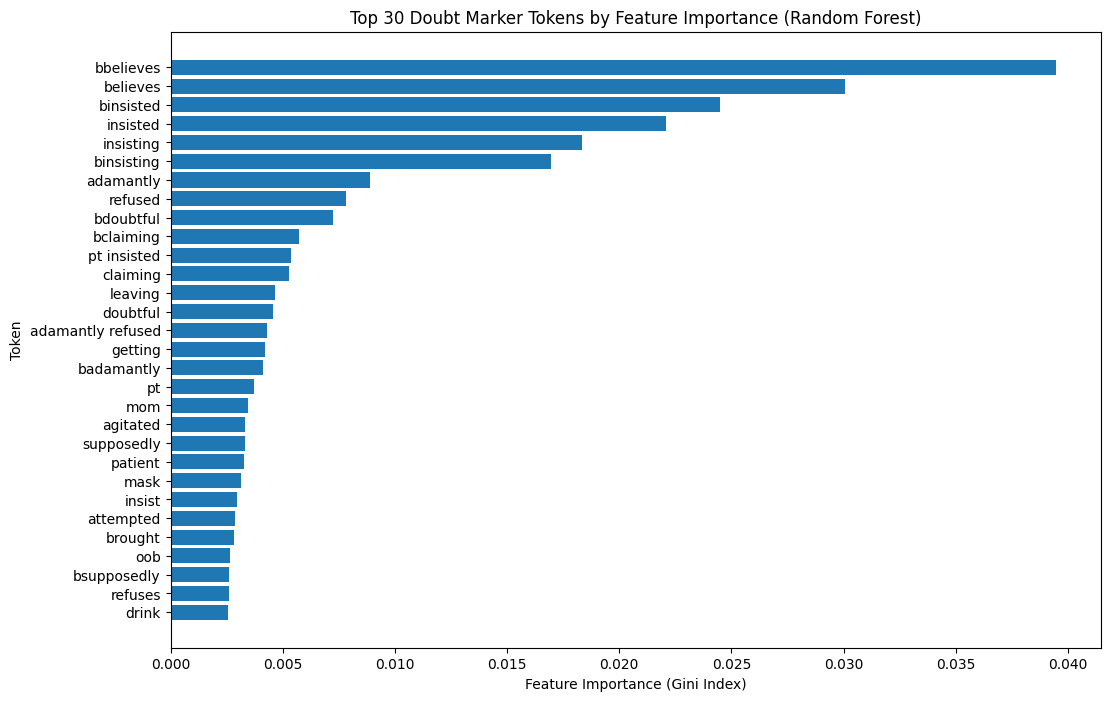

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features (tokens)
feature_names = np.array(vect.get_feature_names_out())

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top 25 tokens and their importances
top_tokens = feature_names[sorted_indices][:30]
top_importances = feature_importances[sorted_indices][:30]

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_tokens)), top_importances, align='center')
plt.yticks(range(len(top_tokens)), top_tokens)
plt.xlabel('Feature Importance (Gini Index)')
plt.ylabel('Token')
plt.title('Top 30 Doubt Marker Tokens by Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important tokens at the top
plt.savefig("doubt_marker_feature_importance_plot.png", bbox_inches='tight')  # Save the figure before showing it
plt.show()



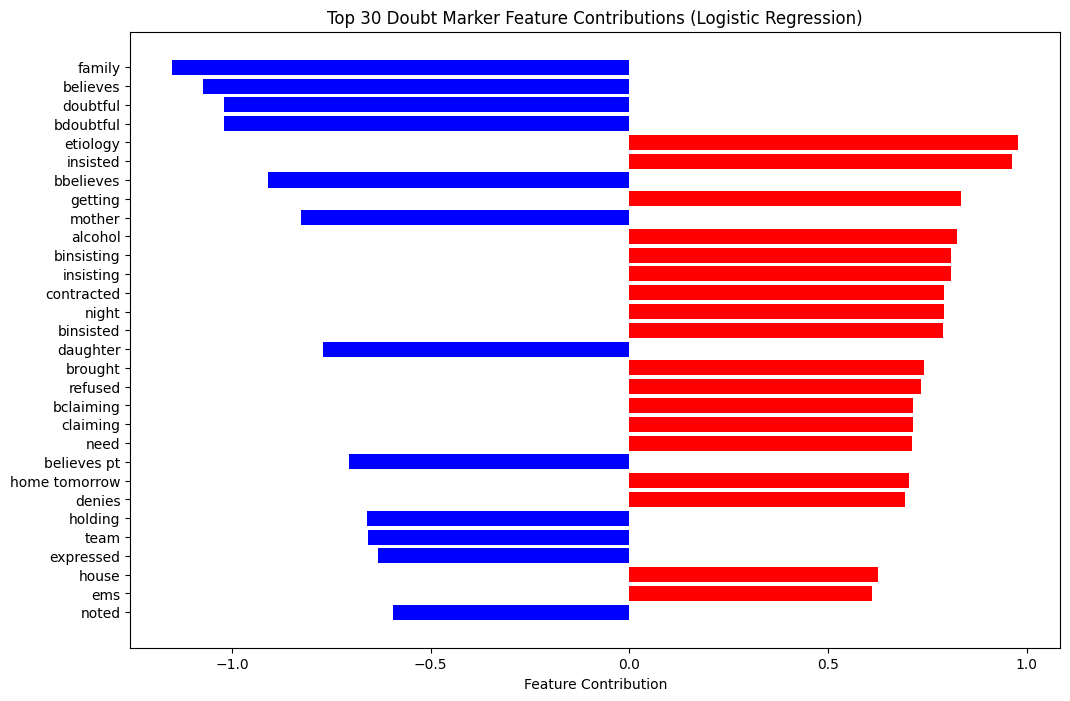

In [38]:
# Calculate feature contributions
coefs = best_lr_model.coef_  # Coefficients for each feature
feature_names = vect.get_feature_names_out()

# Create a DataFrame to store feature contributions
contributions_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs[0]})

# Sort the DataFrame by the absolute value of coefficients to identify significant features
contributions_df['Absolute_Coefficient'] = np.abs(contributions_df['Coefficient'])
contributions_df = contributions_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Select the top N significant features for the plot
top_features = contributions_df.head(30)

# Determine the color for each bar based on the coefficient value
colors = ['red' if coef > 0 else 'blue' for coef in top_features['Coefficient']]

# Plot the feature contributions
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'], align='center', color=colors)
plt.xlabel('Feature Contribution')
plt.title('Top 30 Doubt Marker Feature Contributions (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most significant features at the top
plt.savefig("doubt_marker_feature_contributions_plot.png", bbox_inches='tight')  # Save the figure before showing it
plt.show()
